In [1]:
import pandas as pd
import numpy as np
import matrix_modules


In [2]:
# load in the data
ratings, news, users = matrix_modules.load_dataset_for_matrix()

# create the matrix and user 
R = matrix_modules.create_item_cluster_mat(ratings, news, num_users=len(users), num_clusters=len(news['cluster'].unique()), isALS=False)

In [21]:
# initialize U and V
K = 5 # five latent factors tentatively 
I = len(users) # number of users
M = 30 # number of items
np.random.seed(42)
U = np.random.uniform(0, 1, size=K*I).reshape((I, K))
V = np.random.uniform(0, 1, size=K*M).reshape((M, K))


# initialize a dataframe of the matrix to look at data
df = pd.DataFrame(R)
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,1,0,11,0,2,0,0,1,1,...,0,11,2,0,0,4,0,0,1,0
1,2,3,3,1,2,3,0,2,0,0,...,0,1,1,1,0,3,0,1,1,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,12,1,0,0,5,0,0,0,3,...,4,1,3,3,2,2,0,0,12,3
4,0,8,2,2,1,5,0,1,1,0,...,2,6,5,2,3,2,1,0,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
255986,0,1,1,0,0,1,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
255987,0,2,0,1,1,1,0,0,0,0,...,0,0,1,2,0,0,0,0,0,0
255988,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [24]:
rmse(R-(U @ V.T))

2.524555854805248

In [4]:
from tqdm import tqdm

In [5]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

In [30]:
def SGD(R,U,V,rate=0.01,max_iterations=10,lam=5, diff_threshold=1e-3):

    Uold = np.zeros_like(U)
    Vold = np.zeros_like(V)
    
    error_update = []
    track_update = []

    for t in range(1, max_iterations): # , total=max_iterations, desc="Starting descent"):
        
        for i, m in tqdm(zip(*np.where(R != 0)), total=len(np.where(R != 0)[0]), desc="Iterating Over R", leave=True):

            # Calculate the penalty terms.
            u_penalty = 2 * rate * lam * U[i]
            v_penalty = 2 * rate * lam * V[m]

            # Calculate the error and then update U[i]
            error = R[i, m] - (V[m] * U[i])
            U[i] = U[i] + ((2 * rate * error) * V[m]) - u_penalty

            # Calculate the error again with updated U[i] and then update V[m]
            error = R[i, m] - (V[m] * U[i])
            V[m] = V[m] + ((2 * rate * error) * U[i]) - v_penalty

        # track_rmse += [{
        #     'iteration':i, 
        #     'rmse': rmse(Gnew),
        #     'max residual change': max_update(Gnew, G, relative=False)
        # }]
        track_update += [{
            'iteration':t, 
            'max update':max(max_update(U, Uold), max_update(V, Vold))
        }]
        Uold = U.copy()
        Vold = V.copy()
        if track_update[-1]['max update'] < diff_threshold:
            print("Threshold reached, stopping descent")
            break
        
        # compute error after one sweep of updates
        error_update += [(t, rmse(R-(U @ V.T)))]
        
        # keep track of how much U and V changes
        # update += [(t, max(matrix_modules.max_update(Uold, U), matrix_modules.max_update(Vold, V)))]

    # error = pd.DataFrame(error, columns=['iteration', 'rmse'])
    # update = pd.DataFrame(update , columns=['iteration', 'maximum update'])

    return U, V , error_update, track_update

# U, V = SGD(R, U, V)

U, V, error, updates = SGD(R, U, V,max_iterations=5)
U

Iterating Over R:   0%|          | 0/2446556 [00:00<?, ?it/s]

Iterating Over R: 100%|██████████| 2446556/2446556 [00:35<00:00, 67969.96it/s]


array([[0.01677786, 0.0159673 , 0.01751957, 0.01893402, 0.01973266],
       [0.00469772, 0.0044944 , 0.0049662 , 0.0052972 , 0.00555417],
       [0.03176101, 0.05127617, 0.04879266, 0.03653471, 0.03719903],
       ...,
       [0.00641037, 0.00608435, 0.00688716, 0.00738464, 0.00762923],
       [0.00956598, 0.00749742, 0.00800008, 0.0103411 , 0.00967574],
       [0.00315456, 0.00299914, 0.00339683, 0.00374571, 0.00379793]])

In [36]:
def plot_error_sgd(error):
    # plots rsme as SGD iterates
    error_df = pd.DataFrame(error, columns=["iter", "rmse"])
    plt.plot(error_df["iter"], error_df["error"])

,iter,error
0,1,2.561451
1,2,2.561945
2,3,2.562147
3,4,2.562235


In [34]:
import matplotlib.pyplot as plt

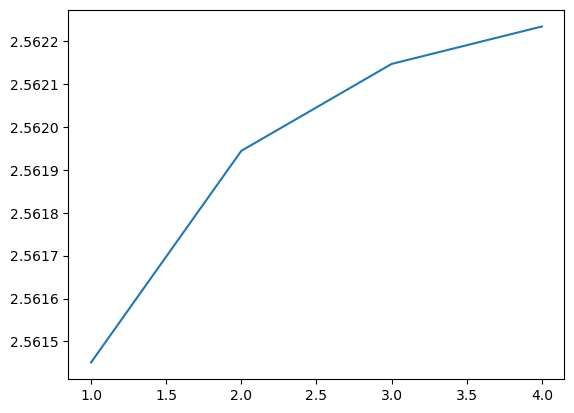

In [26]:
(1, rmse(R-(U @ V.T)))

(1, 2.524555854805248)

In [16]:
R.shape

(255990, 30)

In [7]:
def plot_iter(x, rmse_test, hyper_param, burn_in):
  fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

  axes[0, 0].plot(x, rmse_test[burn_in:], label='test rmse', color="r")
  axes[0, 0].legend()
  axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
  axes[0, 1].legend()
  axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
  axes[1, 0].legend()
  axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
  axes[1, 1].legend()

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, n

In [58]:
pd.DataFrame(U @ V.T)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-4.666942,56.276332,0.993091,39.528913,7.713917,11.649680,24.955317,9.705748,27.514584,11.119666,...,-24.263911,-7.360216,-16.093142,-6.860031,-53.930400,-54.058669,-20.548281,-22.042722,-57.627190,57.423576
1,-0.387409,4.671571,0.082438,3.281346,0.640342,0.967055,2.071573,0.805687,2.284021,0.923058,...,-2.014178,-0.610981,-1.335912,-0.569460,-4.476832,-4.487480,-1.705739,-1.829795,-4.783707,4.766805
2,0.808715,-9.751893,-0.172089,-6.849802,-1.336713,-2.018725,-4.324404,-1.681869,-4.767889,-1.926881,...,4.204593,1.275421,2.788714,1.188746,9.345376,9.367603,3.560727,3.819692,9.985978,-9.950694
3,5.643521,-68.052423,-1.200900,-47.800527,-9.328091,-14.087431,-30.177336,-11.736723,-33.272142,-13.446509,...,29.341251,8.900376,19.460709,8.295526,65.215593,65.370704,24.848106,26.655267,69.685955,-69.439733
4,-1.179005,14.217039,0.250884,9.986153,1.948760,2.943048,6.304439,2.451954,6.950984,2.809151,...,-6.129770,-1.859405,-4.065596,-1.733044,-13.624388,-13.656793,-5.191093,-5.568633,-14.558305,14.506866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255985,0.404685,-4.879898,-0.086114,-3.427676,-0.668898,-1.010180,-2.163954,-0.841616,-2.385876,-0.964221,...,2.104000,0.638227,1.395487,0.594855,4.676475,4.687597,1.781806,1.911394,4.997035,-4.979379
255986,1.209942,-14.590087,-0.257467,-10.248185,-1.999894,-3.020272,-6.469864,-2.516293,-7.133375,-2.882862,...,6.290612,1.908195,4.172275,1.778518,13.981885,14.015140,5.327305,5.714751,14.940308,-14.887519
255987,-0.375782,4.531368,0.079964,3.182866,0.621124,0.938032,2.009401,0.781506,2.215473,0.895355,...,-1.953729,-0.592644,-1.295819,-0.552369,-4.342473,-4.352802,-1.654547,-1.774879,-4.640139,4.623744
255988,1.611729,-19.435036,-0.342964,-13.651314,-2.664002,-4.023218,-8.618321,-3.351881,-9.502164,-3.840178,...,8.379544,2.541851,5.557768,2.369113,18.624868,18.669166,7.096351,7.612456,19.901555,-19.831237
